# Expectation-Maximisation

This is a jupyter notebook explaining illustrating [the course on Expectation-Maxmisation and Gaussian Mixture Models](https://unruffled-beaver-a60938.netlify.app/courses/expectation-maximisation/). Check it out before diving into the code!
Note also that the proposed code is didactic and do not aim at being optimised. A good exercise when you're confortable with the EM algorithm is to code it in a matrix way yourself and remove as much as possible the for loops appearing in the following code to have better performances! Otherwise, one can still use the [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) package that does all of it for you.

## Data and visualisation

Let us first generate some data and visualise it.

Text(0, 0.5, '$y$')

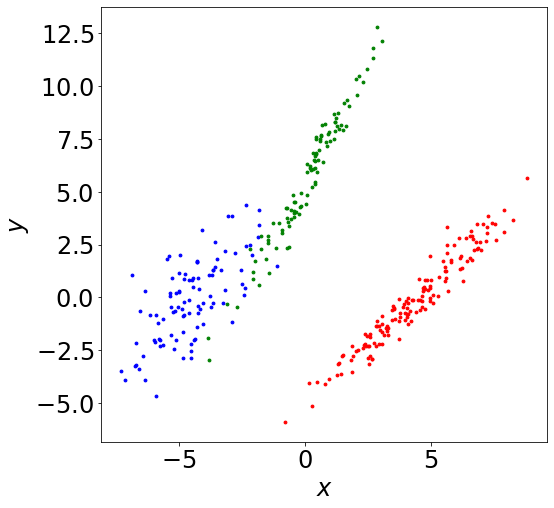

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Nice looking plots
plt.rcParams['savefig.dpi'] = 90       #Number of dpi of saved figures
plt.rcParams['font.size'] = 24
plt.rcParams['axes.formatter.limits']=(-3, 3)
plt.rcParams['axes.formatter.use_mathtext']=True

# Generate dataset
centres = np.array([[-4.5, 0], [4.5, 0], [0, 5.5]])  # Generate three centres
covariances = np.array([[[1.2, 0.7], [0.7, 1.9]], 
                        [[1.5, 1.3], [1.3, 1.8]], 
                        [[0.8, 1.1], [1.1, 2.8]]])   # Create three covariance matrices
Npoints = [100, 150, 100]
np.random.seed(30)
d1 = np.random.randn(Npoints[0], 2)@np.array(covariances[0]) + centres[0]
d2 = np.random.randn(Npoints[1], 2)@np.array(covariances[1]) + centres[1]
d3 = np.random.randn(Npoints[2], 2)@np.array(covariances[2]) + centres[2]

data = np.vstack((d1, d2, d3))  # Concatenate the data

fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(d1.T[0], d1.T[1], s=8, color='b')
plt.scatter(d2.T[0], d2.T[1], s=8, color='r')
plt.scatter(d3.T[0], d3.T[1], s=8, color='g')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

Our dataset is hence made of three Gaussian components that we create by hand. Now imagine you are given the dataset without this knowledge (the colors) and you have to cluster it with the Gaussian Mixture Model.

## Coding Expectation-Maximisation

We need to create the two functions corresponding the both Expectation (E) and Maximisation (M) steps.

Let's first define a function computing the Gaussian probability of a set of datapoints given parameters $\mu$, the centre and $\Sigma$, the covariance.

In [3]:
def gaussian_prob(x, mu, sig):
    '''
    Computes the probability of a datapoint given parameters of a D-dimensional Gaussian distribution.
    
    x: (D,) numpy array
        Datapoint
    mu: (D,) numpy array
        Centre of Gaussian
    sig: (D,D) numpy array
        Covariance matrix
    '''
    D = len(x)
    det = np.linalg.det(sig)
    inv_sig = np.linalg.inv(sig)
    
    mahal_dist = (x-mu).T @ inv_sig @ (x-mu)
    
    prob = 1/np.sqrt( (2*np.pi)**D * np.abs(det) ) * np.exp(-1/2*mahal_dist)
    
    return prob

The E-step consists in computing the probability of the hidden (or latent variables)

In [5]:
def E_step(X, pis, mus, sigs):
    '''
    Computes the E-step of the EM algorithm. As such, it estimates the responsibilities, 
    i.e. the probabilities of each datapoint being generated by each component of the model.
    
    X: (N,D) numpy array
        Dataset
    pi: (K,) numpy array
        Amplitudes of Gaussian components
    mu: (K,D) numpy array
        Centre of Gaussian components
    sig: (K,D,D) numpy array
        Covariance matrices of Gaussian components
    
    return:
    resp: (K,) numpy array
        Responsibilities of the E-step 
    '''
    
    N,D = X.shape # Number of datapoints
    K = len(pis)   # Number of components in the Gaussian mixture model
    
    resp = np.zeros((N,K)) # The responsibility is a matrix NxK with all association of datapoints to clusters
    
    for i in range(N):
        for k in range(K):
            prob = gaussian_prob(X[i,:], mus[k], sigs[k])
            
            resp[i,k] = pis[k] * prob    # This is the numerator of the E-step
            
        normalisation = np.sum(resp[i,:])  # Denominator of the E-step
        resp[i,:] = resp[i,:] / normalisation  # Real value of the responsibility   
    
    return resp

Now, we can perform the M-step in which we use the current values of the responsibilities to update parameters of the model, namely $\{ \boldsymbol{\pi}_k \}$, $\{ \boldsymbol{\mu}_k \}$ and $\{ \boldsymbol{\Sigma}_k \}$.
These are given by the last three equations of the lesson that we re-write here:

$$
\pi_k^{(t+1)} = \displaystyle \frac{1}{N} \sum_{i=1}^N p_{ik}, \\
\boldsymbol{\mu}_k^{(t+1)} = \frac{\sum_{i=1}^N \boldsymbol{x}_i p_{ik}}{\sum_{i=1}^N p_{ik}}, \\
\boldsymbol{\Sigma}_k^{(t+1)} = \displaystyle \frac{\sum_{i=1}^N p_{ik} (\boldsymbol{x}_i - \boldsymbol{\mu}_k) (\boldsymbol{x}_i - \boldsymbol{\mu}_k)^\mathrm{T}}{\sum_{i=1}^N p_{ik}}.
$$

In [13]:
def M_step(X, resp):
    '''
    Computes the M-step of the EM algorithm. As such, it uses the responsibilities and the dataset
    to update values of the parameters.
    
    X: (N,D) numpy array
        Dataset
    resp: (N,K) numpy array
        Responsibility matrix computed in the E-step
    
    return:
    resp: (K,) numpy array
        Responsibilities of the E-step 
    '''
    pis = update_pis(X, resp)
    mus = update_mus(X, resp)
    sigs = update_sigs(X, resp, mus)
    
    return pis, mus, sigs


def update_pis(X, resp):
    '''
    Implements the update equation of the amplitudes of clusters
    
    X: (N,D) numpy array
        Dataset
    resp: (N,K) numpy array
        Responsibility matrix computed in the E-step
    '''
    N, D = X.shape
    K = len(pis)
    
    new_pis = np.zeros(K)  # Initialisation of the new values
    for k in range(K):
        new_pis[k] = 1/N * np.sum(resp[:,k], axis=0)
    
    return new_pis

def update_mus(X, resp):
    '''
    Implements the update equation of the centre positions of clusters
    
    X: (N,D) numpy array
        Dataset
    resp: (N,K) numpy array
        Responsibility matrix computed in the E-step
    '''
    N, D = X.shape
    K = len(mus)
    
    new_mus = np.zeros((K,D))  # Initialisation of the new values
    for k in range(K):
        new_mus[k] = X.T @ resp[:,k]     # Matrix multiplication of data and the column k of the responsibility matrix
        new_mus[k] /= np.sum(resp[:,k])  # Normalization
    
    return new_mus

def update_sigs(X, resp, mus):
    '''
    Implements the update equation of the variances of clusters
    
    X: (N,D) numpy array
        Dataset
    resp: (N,K) numpy array
        Responsibility matrix computed in the E-step
    mus: (K,D) numpy array
        Current values of centre positions for Gaussian components
    '''
    
    N, D = X.shape
    K = len(mus)
    
    new_sigs = np.zeros((K, D, D))  # Initialisation of the new values
    for k in range(K):
        Nk = np.sum(resp[:,k]) # normalization
        for i in range(N):
            new_sigs[k] += resp[i,k] * np.outer(X[i] - mus[k], X[i] - mus[k]) / Nk  # Weighted sum of all covariances data_i/mu_k
            
    return new_sigs

## Application

Let's now test our algorithm based on the data we generated in the first place!

We first need some initial values of the parameters. They can be made random, and we choose simply centres by hand in this case (in more complex setups, we can use K-Means as an initial guess). Then $\forall k$, we set $\pi_k = 1/K$ and $\boldsymbol{\Sigma}_k = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}$.


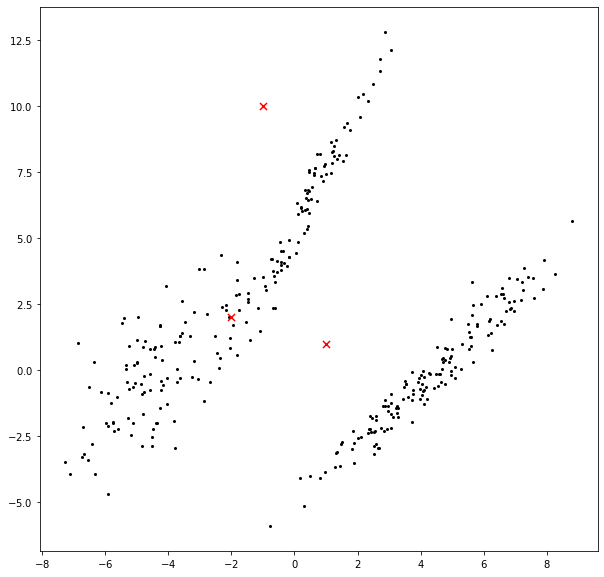

In [9]:
# Initialisation of the algorithm
K = 3
pis = 1/K * np.ones(K)     # Initial amplitudes, uniform 1/K
mus = np.array([[-2,2], [-1, 10], [1, 1]])  # Initial centres, you can make put them randomly
sigs = np.array([ [[1,0],[0,1]], [[1,0],[0,1]], [[1,0],[0,1]]])  # Initial covariance matrices, chosen as spherical unit variance

plt.figure(figsize=(10,10))
plt.scatter(data.T[0], data.T[1], s=4, color='k')
plt.scatter(mus[:,0], mus[:,1], marker='x', s=50, color='r')

Now let's run our algorithm and see what we get!

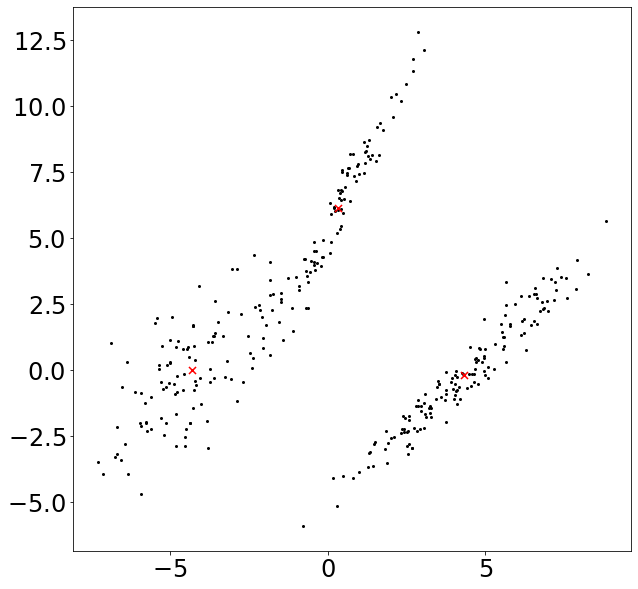

In [36]:
# Run EM algorithm
T = 50
for t in range(T):
    resp = E_step(data, pis, mus, sigs)
    pis, mus, sigs = M_step(data, resp)

# Plot
plt.figure(figsize=(10,10))
plt.scatter(data.T[0], data.T[1], s=4, color='k')
plt.scatter(mus[:,0], mus[:,1], marker='x', s=50, color='r')


Now we plot the covariances ellipses thanks to this small function. We see that they fit really well the observed dataset.

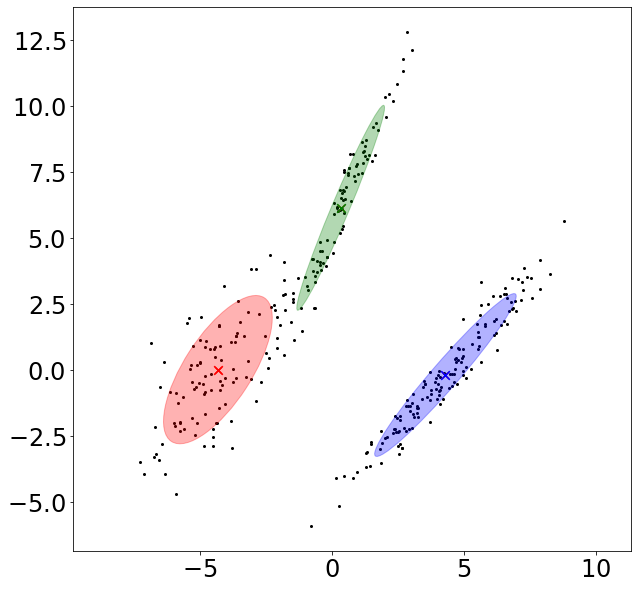

In [40]:
# Code for beautiful ellipse plot
def draw_ellipse(covariances, means, ax, color='k'):
    v, w = np.linalg.eigh(covariances)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(means, v[0], v[1],
                              180 + angle, color=color)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.3)
    ax.add_artist(ell)
    ax.scatter(means.T[0], means.T[1], s=75, marker='x', color=color)
    ax.set_aspect('equal', 'datalim')
    
# Plot
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(data.T[0], data.T[1], s=4, color='k')
plt.scatter(mus[:,0], mus[:,1], marker='x', s=50, color='r')
    
draw_ellipse(sigs[0], mus[0], ax, color='r')
draw_ellipse(sigs[1], mus[1], ax, color='g')
draw_ellipse(sigs[2], mus[2], ax, color='b')

Let's compare the obtained results to the _real_ values we used to create the data.

In [41]:
print('Real positions of clusters = \n' + str(centres))
print('Learned positions of clusters = \n' + str(mus))

print('\n')
print('Real amplitudes of clusters = ' + str(Npoints/np.sum(Npoints)))  # Convert to proportions
print('Learned amplitudes of clusters = ' + str(pis))

print('\n')
print('Real covariances of clusters = \n' + str(covariances))  # Convert to proportions
print('Learned covariances of clusters = ' + str(sigs))

Real positions of clusters = 
[[-4.5  0. ]
 [ 4.5  0. ]
 [ 0.   5.5]]
Learned positions of clusters = 
[[-4.30651838  0.02321968]
 [ 0.34256347  6.15231143]
 [ 4.3108174  -0.18083951]]


Real amplitudes of clusters = [0.28571429 0.42857143 0.28571429]
Learned amplitudes of clusters = [0.31143893 0.25998964 0.42857143]


Real covariances of clusters = 
[[[1.2 0.7]
  [0.7 1.9]]

 [[1.5 1.3]
  [1.3 1.8]]

 [[0.8 1.1]
  [1.1 2.8]]]
Learned covariances of clusters = [[[2.12169874 2.01942483]
  [2.01942483 3.94372844]]

 [[1.38056258 3.14751753]
  [3.14751753 7.53157447]]

 [[3.59487642 4.00685022]
  [4.00685022 4.75459466]]]


We see that the values we learnt aren't far from the true one, even though our initial guess is very crude! We also see that the cluster we have in index "1" corresponds to the "true" one of index "2" and our estimated "2" is the true "1" class. Note that the indexing does not matter at all, we still found the right clusters!

## Probability of datapoints

What if we now want to have access to the probability of each datapoint of being generated by one or the other component of the model? Well, for that we can use our last estimate of the responsibilities $p_{ik}$. Remembering that it encodes $p(z_i = k | \boldsymbol{x}_i, \boldsymbol{\theta}_k)$, i.e. the probability of a datapoints being in the cluster $k$ knowing its position and the parameters of the model, we can plot them for each of our cluster!

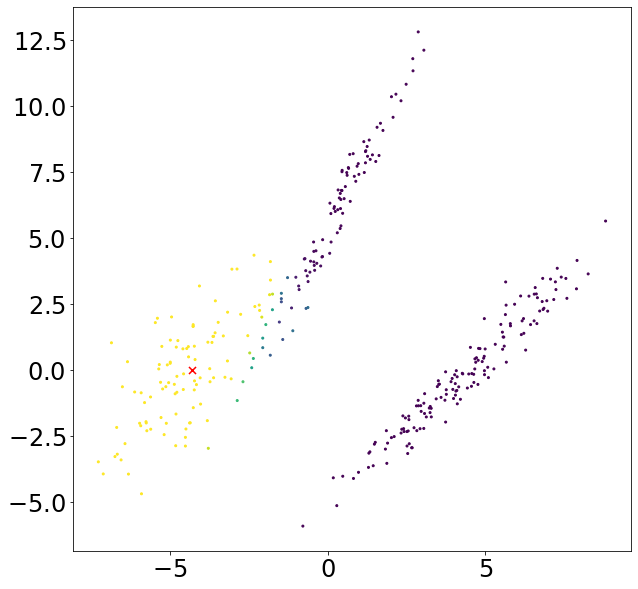

In [45]:
probability_cluster0 = resp[:,0] # You can change 0 to any of the three clusters

fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(mus[0,0], mus[0,1], marker='x', s=50, color='r')   # Centre of cluster 0
plt.scatter(data.T[0], data.T[1], s=4, c=probability_cluster0) # Probability of each datapoint to be in cluster 0

In the figure above, we basically see in yellow the datapoints with high probability of being in cluster 0 (with centre as the red cross) and in dark those with low probability.

We can extend this to predict the class of each datapoint as simply taking the value of $k$ that maximises the probability $p_{ik}$ for a datapoint $i$. This reads
$$
z_i = \operatorname*{argmax}_{k\in \{1, \ldots, K\}} p_{ik}.
$$

In Python, this gives

In [48]:
z = np.argmax(resp, axis=1)
print(z)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 0 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


We see above that for instance the datapoint $0$ has a higher probability to be in cluster $0$! Let's now see the dataset coloured by these associations.

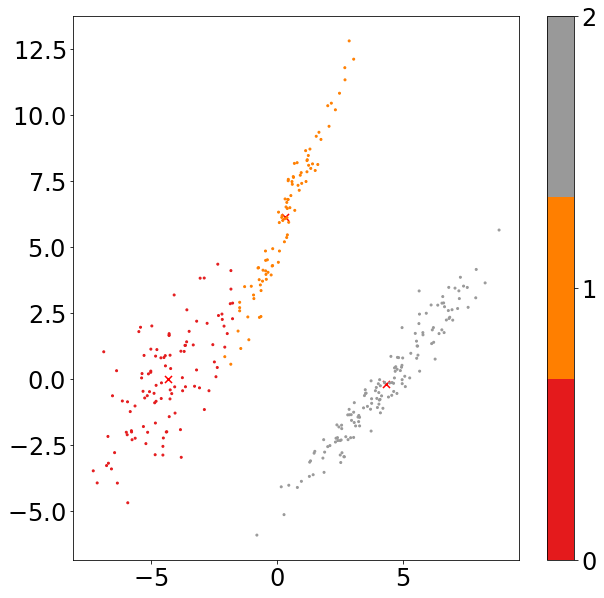

In [75]:
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(mus[:,0], mus[:,1], marker='x', s=50, color='r')   # Centre of clusters
plt.scatter(data.T[0], data.T[1], s=4, c=z, cmap=plt.cm.get_cmap('Set1', 3)) # Colours are given by z here, "cmap" is just to make the plot look good
plt.colorbar(ticks=[0, 1, 2])  # Add the colorbar

## Conclusions

In this tutorial, you have learnt how to use Python to implement your own Expectation-Maximisation algorithm and applied to a generated random dataset. Here, we have directly been using $K=3$ clusters. You can change the code to investigate what happens when using other values than $K=3$. In practice many ways have been proposed to alleviate this drawback of the Gaussian Mixture clustering in the litterature based on the BIC or AIC.

You can also investigate what happens in higher dimensions. For practical reasons, we have been working with a dataset in 2 dimensions, what about $D = 10$ or higher where visualisation is not possible?

For those more interesting in the coding part, don't hesitate to investigate ways to accelerate the computations we have made using for instance matrix calculus and sparse efficient storage. You can also check the [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) code that is publicly available to see how they did!

One fun way of circumventing all that is proposed in [one of my papers](https://arxiv.org/abs/2010.07955) that uses statistical physics to investigate the data. Check it out for more info!